## Autoencoders

In [1]:
cd ../../src

/home/kuba/Projects/notebooks/examples-counterexamples/src


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import theano
import theano.tensor as T

from fetch_mnist import preprocessed_mnist
from neural_nets.autoencoder import Autoencoder 

In [3]:
X_train, X_test, y_train, y_test = preprocessed_mnist(random_state=0, preprocess='scale_to_unit_cube')

In [4]:
def train_autoencoder(**kwargs):
  autoencoder = Autoencoder(**kwargs)

  %time autoencoder.fit(X_train)

  plt.plot(autoencoder.losses)
  plt.show()
  return autoencoder

def present_autoencoder_reconstruction(autoencoder):
  def plot_x(X1, X2, title, j=5):
    f, axes = plt.subplots(2, j, figsize=(20, 40 / j))
    f.suptitle(title)
    for k, x in zip(range(2), [X1, X2]):
      for i in range(j):
        ax = axes[k, i]
        img = x[i, :].reshape(28, 28)
        ax.imshow(img, cmap='gray')
        ax.axis('off')
    plt.show()
  
  X_test_retrieved = autoencoder.retrieve(X_test)
  X_train_retrieved = autoencoder.retrieve(X_train)
  plot_x(X_train, X_train_retrieved, 'train', 10)
  plot_x(X_test, X_test_retrieved, 'test', 10)
 

In [5]:
shared_args = (dict(
  initialization_type='xavier',
  optimization_params={
    'method': 'nesterov',
    'decay': 0.9},
  n_iter=250,
  hidden_sizes = [250],
  batch_size = 1000,
  learning_rate=0.0001))

CPU times: user 32.1 s, sys: 1.24 s, total: 33.4 s
Wall time: 18.4 s


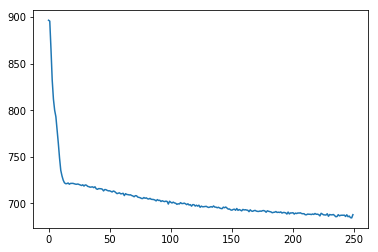

CPU times: user 32.4 s, sys: 1.26 s, total: 33.7 s
Wall time: 18.6 s


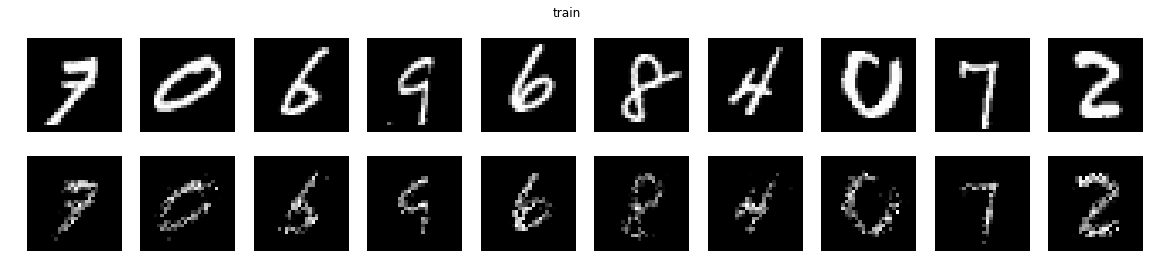

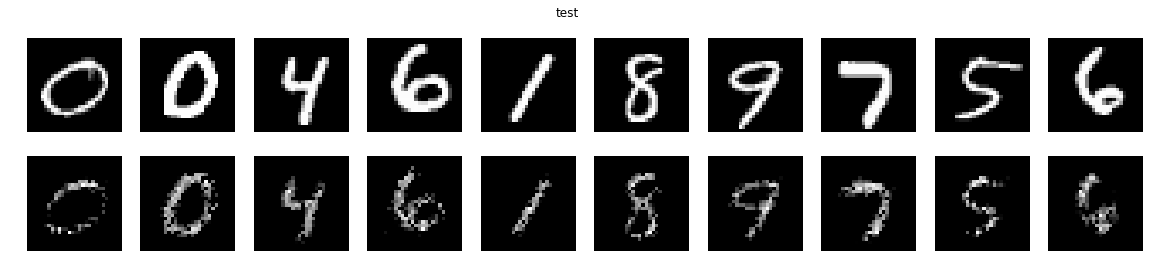

In [6]:
args_dict = (dict(
  lmbda=0.0005,
  l1_ratio=0.5))

args_dict.update(shared_args)

%time autoencoder = train_autoencoder(**args_dict)

present_autoencoder_reconstruction(autoencoder)

CPU times: user 31 s, sys: 140 ms, total: 31.1 s
Wall time: 15.8 s


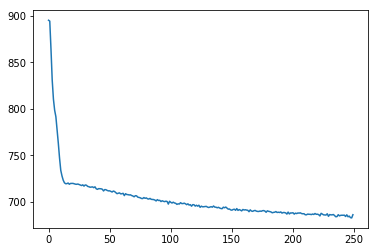

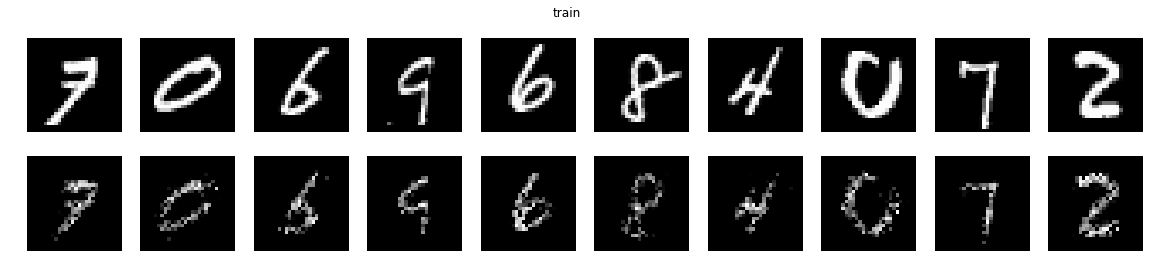

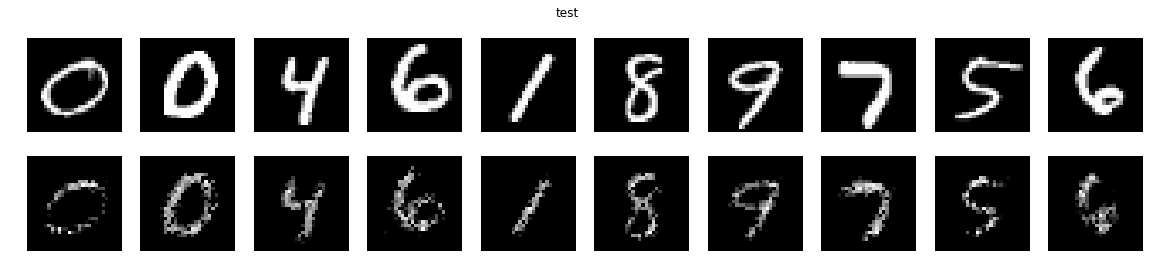

In [7]:
args_dict = (dict(
  lmbda=0.0001,
  l1_ratio=0.5))

args_dict.update(shared_args)

autoencoder = train_autoencoder(**args_dict)

present_autoencoder_reconstruction(autoencoder)

In [8]:
# more iterations

CPU times: user 30 s, sys: 160 ms, total: 30.2 s
Wall time: 15.3 s


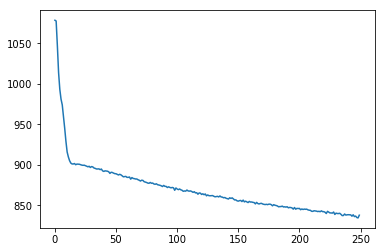

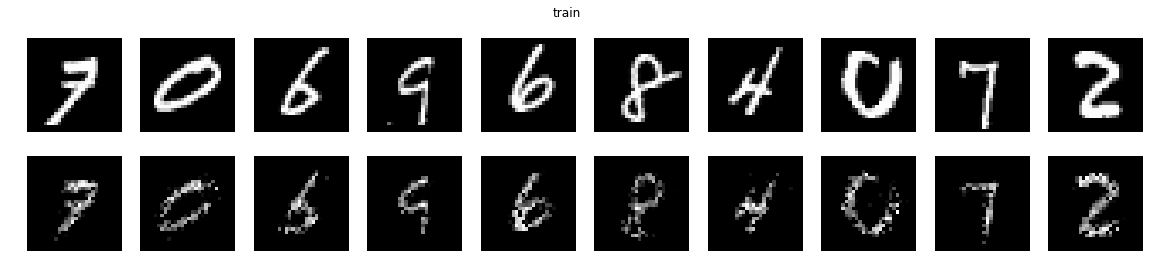

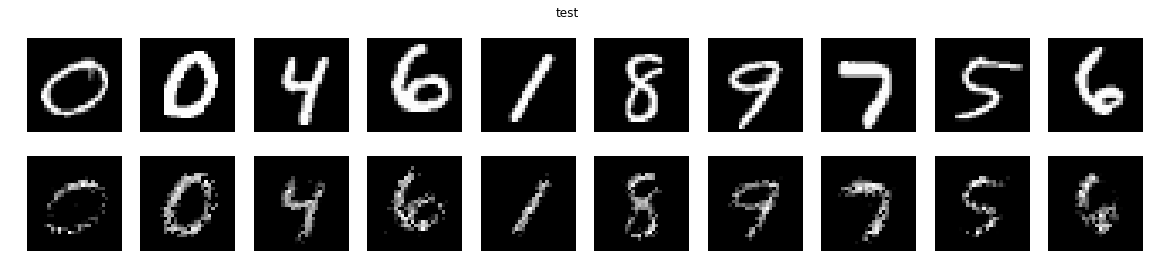

In [9]:
args_dict = (dict(
  lmbda=0.05,
  l1_ratio=0.5))

args_dict.update(shared_args)

autoencoder = train_autoencoder(**args_dict)

present_autoencoder_reconstruction(autoencoder)

CPU times: user 29.9 s, sys: 104 ms, total: 30 s
Wall time: 15.2 s


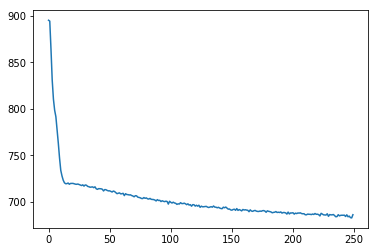

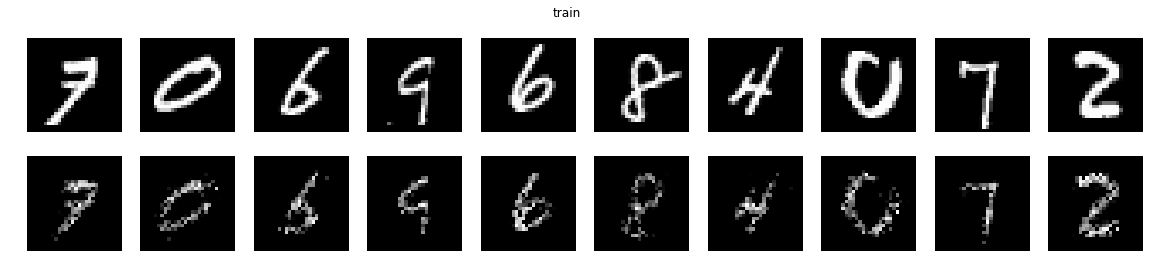

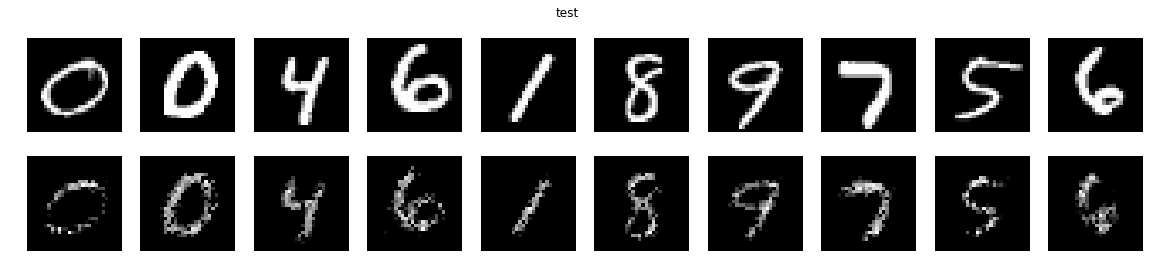

In [10]:
args_dict = (dict(
  lmbda=0.0001,
  l1_ratio=0.5))

args_dict.update(shared_args)

autoencoder = train_autoencoder(**args_dict)

present_autoencoder_reconstruction(autoencoder)